# Imports

In [2]:
!pip install corner

  Stored in directory: C:\Users\doug\AppData\Local\pip\Cache\wheels\70\d8\e5\e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [4]:
!pip install nestle

  Stored in directory: C:\Users\doug\AppData\Local\pip\Cache\wheels\8d\6b\8a\617f2fd643e9003bc64fb4d3be6d59b8fd391c8b0dab23eb61
Successfully built nestle


In [29]:
import numpy
import scipy
import corner
import nestle
import pandas
import warnings
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import astropy
import astropy.io
import astropy.io.ascii
#---------------------------------------------------------------------
import Library_GraphTwoDimensionDensityColorMap
#---------------------------------------------------------------------
warnings.simplefilter('ignore')
print ("done importing")

done importing


# What does the theorist give you?

In [8]:
# Both data set cases:
def my_model( v, g, t):
    return v*t -.5*g*t**2


# Case 1--Height Error Only

## What does the experimentalist give you?

### With a perfect stopwatch, but not so perfect meter stick?

In [9]:
#(YOU NEED THIS CODE)
#The experimentalist has a perfect stopwatch,
#    and knows his height measurement error

# Read in a file using astropy called "1D_Generated_Data.astropydat"

data_with_height_error_only = pandas.read_csv( "1D_Generated_Data.dat" ,sep=' ',header=0)
height_standard_deviation = 10

In [10]:
#These should run without error
assert data_with_height_error_only['time'][0] == .1

Text(0.5, 1.0, 'Probability Density Result of Measuring Zero')

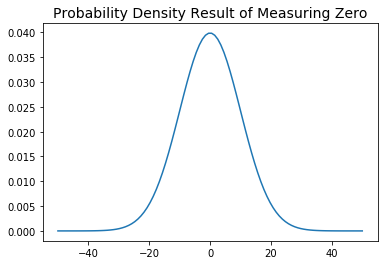

In [11]:
#plot the instrument error function of height
Points = numpy.linspace(-50, 50, 100)
Values = scipy.stats.norm.pdf(Points, 0, 10)
plt.plot(Points,  Values, )
plt.title("Probability Density Result of Measuring Zero", fontsize=14)

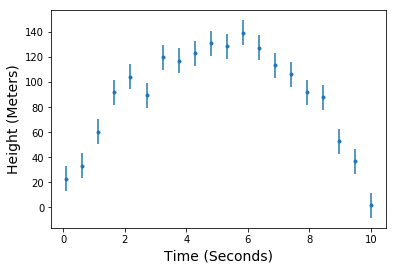

In [12]:
#Plot the 1D-error data
times_1d = data_with_height_error_only['time']
heights_1d = data_with_height_error_only['height']
plt.errorbar( times_1d, heights_1d, yerr = [height_standard_deviation]*len(times_1d) , fmt = ".")
plt.ylabel('Height (Meters)',fontsize=14)
plt.xlabel('Time (Seconds)',fontsize=14)
plt.show()

## What is the correct single datapoint likelihood function?
###  "Likelihood function" fixes the observation values and allows the parameters to vary:

In [13]:
def probability_of_single_measurement_1D(
    observed_time, 
    observed_height,
    v,
    g,
    ):

    ##########################################################
    ##########################################################
    #If we assume a velocity and gravitational constant
    #    What height should we observe? 
    #    (students do this)
    assume_model_is_correct_height = my_model(v, g, t = observed_time )
    
    #    What is the probability of a measuring an observed height and observed time?
    #    (students do this)
    def gaussian_centered_on_model( possible_height_measurement ):
        #Create a 1D Gaussian with a mean=assume_model_is_correct_height,
        #sigma=height_standard_deviation, which returns a probability for a 
        #given possible_height_measurement
        result = scipy.stats.norm.pdf(
            possible_height_measurement, 
            loc = assume_model_is_correct_height, 
            scale = height_standard_deviation)
        return result
    
    
    #Return the associated probability by plugging in the observed height:
    likelihood_value = gaussian_centered_on_model( 
        possible_height_measurement = observed_height
        )
    #
    ##########################################################
    ##########################################################
    
    
    return(likelihood_value)


In [14]:
#Test for the correct number in the 1D-height-error-only case:
print( probability_of_single_measurement_1D (
    times_1d[0],
    heights_1d[0],
    v = 100,
    g = 20
    ) )
#Expected result: 0.017829561071290335

0.01782956107129033


In [15]:
#(provided by instructors below):
def generate_single_data_point_likelihood_function(
    observed_time,
    observed_height,
    probability_of_single_measurement_function,
    ):
    def single_data_point_likelihood_function(
        vg_vector, 
        ):
        v = vg_vector[0]
        g = vg_vector[1]
        likelihood_value = probability_of_single_measurement_function(
            observed_time = observed_time,
            observed_height= observed_height,
            v = v,
            g = g,
            )
        return likelihood_value
    
    return single_data_point_likelihood_function




In [16]:
#Test for the height-only error case:
likelihood_function_for_first_datapoint1d = generate_single_data_point_likelihood_function(
    observed_time = times_1d[0],
    observed_height = heights_1d[0],
    probability_of_single_measurement_function = probability_of_single_measurement_1D,
    )
print ( likelihood_function_for_first_datapoint1d(  [100, 20]) )
#Expected result: likelihood_fn(100, 20) == 0.017829561071290335

0.01782956107129033


## What is the all-data log-likelihood function?

In [17]:
#(provided below by instructors)
#numpyize the data:
#    Each row of the datapoints is a datapoint
datapoints1d = numpy.vstack([times_1d, heights_1d]).T

#    Looks like:
#   [
#   [time0, height0 ],
#   [time1, height1 ],
#   ...
#   [timeN, heightN ],
#   ]
#

def generate_log_likelihood_function_fixing_all_observations(
        datapoints = None, 
        probability_of_single_measurement_function = None,
        ):    
    #Make a list where each element is a single-datapoint likelihood function
    single_datapoint_likelihood_function_list = []
    for datapoint in datapoints:
        single_datapoint_likelihood_function = generate_single_data_point_likelihood_function(
            observed_time = datapoint[0],
            observed_height = datapoint[1],
            probability_of_single_measurement_function = probability_of_single_measurement_function,
            )
        single_datapoint_likelihood_function_list.append( single_datapoint_likelihood_function )

    #Define a log-likelihood funciton for all the data using the list defined above:
    def log_likelihood_function_fixing_all_observations(parameters):
        result = 0
        for single_datapoint_likelihood_function in single_datapoint_likelihood_function_list:
            result += numpy.log( single_datapoint_likelihood_function(parameters) )
        return result
            
    return log_likelihood_function_fixing_all_observations




In [18]:
loglikelihood_alldata_1d = generate_log_likelihood_function_fixing_all_observations(
    datapoints = datapoints1d,
    probability_of_single_measurement_function = probability_of_single_measurement_1D,
    )
loglikelihood_alldata_1d( numpy.array([40, 10]) )

-514.1733970975973

## What is the posterior using MCMC?

In [19]:
#Define the required functions for the mcmc tools:
def bounds_to_ppf(bounds):
    ppfs={}
    for key in bounds.keys():
        ppfs[key] = scipy.interpolate.interp1d([0.,1.],bounds[key])
    return ppfs

def prior_transform(nested_parameters):
        actual_parameters = numpy.empty(n_varied_parameter_dim, dtype=numpy.float)
        for i in range(n_varied_parameter_dim):
            actual_parameters[i] = ppfs[varied_param_names[i]](nested_parameters[i])
        return actual_parameters

varied_param_names = ['v','g']
parameter_bounds={'v':(0,100),'g':(0,20)}
n_varied_parameter_dim = len(varied_param_names) 
ppfs=bounds_to_ppf(parameter_bounds)

In [20]:

sample_result1d = nestle.sample(
    loglikelihood_alldata_1d, 
    prior_transform, 
    n_varied_parameter_dim,
    npoints=100, 
    maxiter=None,
    maxcall=None
    )


Best fit: ['v', 'g'] 
 [53.02084822 10.44688757]
Covariance: ['v', 'g'] 
 [[2.21395231 0.54245784]
 [0.54245784 0.14230712]]


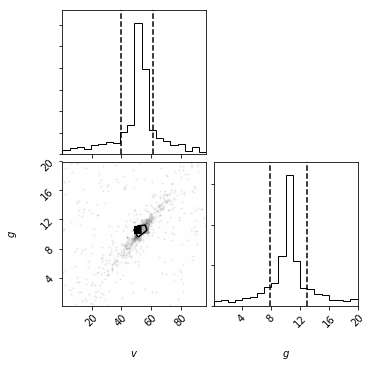

In [22]:
vparameters1d, cov1d = nestle.mean_and_cov(sample_result1d.samples, sample_result1d.weights)
print('Best fit:', varied_param_names, '\n',vparameters1d)
print('Covariance:',varied_param_names, '\n', cov1d)
fig = corner.corner(
    sample_result1d.samples, 
    labels=["$v$", "$g$"],
    quantiles=(0.16, 0.84),
    levels=(1-numpy.exp(-0.5),),
    #truths=[v, g]
    )

plt.show()

# CASE2: JOINT HEIGHT AND TIME ERROR


In [31]:
#(YOU NEED THIS CODE)
#The experimentalist knows 
#    his joint time, and height measurement error

#DATA:
data_with_heights_and_times_error = astropy.io.ascii.read( "2D_Generated_Data.dat" )
times_2d = data_with_heights_and_times_error['time']
heights_2d = data_with_heights_and_times_error['height']

#ERROR:
covariance_matrix = numpy.array(
    [
        [.58,   13.35],
        [13.35, 501.77]
    ])
covariance_matrix_list = [covariance_matrix]*len(times_2d)

def generate_experiment_error_function(mu, cov):
    def experiment_error_function(Point):
        x = Point
        return scipy.stats.multivariate_normal.pdf(x, mu, cov)
    return experiment_error_function

DomainMinimumPoint [ -2 -40]
DomainMaximumPoint [ 2 40]
PlugInPointsCount 10000
PointsToPlugInDataset.shape (10000, 2)
PointsToPlugInDataset[0] [ -2. -40.]
MaxObservedValue 0.014979618176543238
MinObservedValue 2.5933311664554566e-12
Z.shape (100, 100)


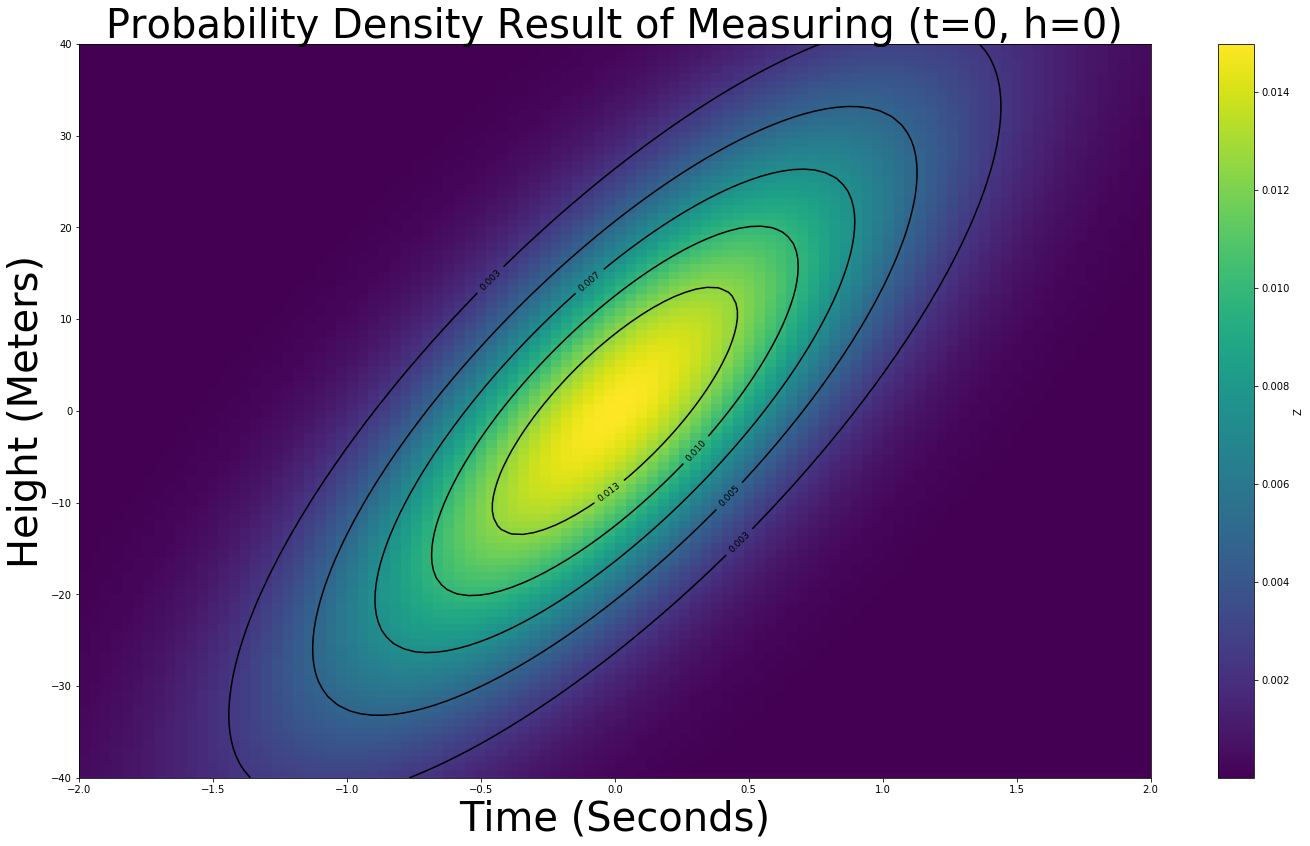

In [32]:
#PLOTS (YOU DONT NEED THIS CODE)
#    (You dont need this code but its here for illustration):
#Make a quick plot of the experimentalist lab testing of his camera:
experiment_error_function = generate_experiment_error_function(
    numpy.array([0,0]), 
    covariance_matrix)
Library_GraphTwoDimensionDensityColorMap.Main(
    Function = experiment_error_function,
    DomainMinimumPoint  = numpy.array([-2, -40]),
    DomainMaximumPoint  = numpy.array([2, 40]),
    ShowContours = True,
    PrintExtra = False,
    )
plt.title("Probability Density Result of Measuring (t=0, h=0)", fontsize=40)
plt.ylabel('Height (Meters)',fontsize=40)
plt.xlabel('Time (Seconds)',fontsize=40)
plt.draw()


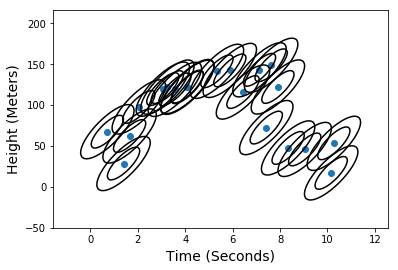

In [33]:
#PLOTS  (YOU DONT NEED THIS CODE)
#Plot the data:
plt.scatter(times_2d,heights_2d)
for i in range(len(times_2d)):
    np=numpy
    mu = np.array([times_2d[i],heights_2d[i]])
    cov = covariance_matrix
    Function = generate_experiment_error_function(mu, cov)
    xmin=-3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    xmax=3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    ymin=-3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    ymax=3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    X, Y = numpy.mgrid[xmin:xmax:50j, ymin:ymax:50j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)
    CS = plt.contour(X, Y, Z, 2,
                             colors='k', # negative contours will be dashed by default
                             )
plt.xlabel('Time (Seconds)',fontsize=14)
plt.ylabel('Height (Meters)',fontsize=14)
plt.draw()



## What is the correct single datapoint likelihood function?
###  "Likelihood function" fixes the observation values and allows the parameters to vary:

In [34]:
def probability_of_single_measurement_2D(
    observed_time, 
    observed_height,
    v,
    g,
    ):


    ##########################################################
    ##########################################################
    #If we assume a velocity and gravitational constant
    #    What height should we observe? 
    #    (students do this)
    observed_timeheight_vector = numpy.array([observed_time, observed_height])   

    #    What is the probability of a measuring an observed height and observed time?
    #    (students do this)
    def kernel_density_estimation_centered_on_model2d( possible_timeheight_vector ):
        result = 0
        kernel_count = 20
        for t in numpy.linspace(0, 10, kernel_count):
            
            assume_model_is_correct_time_choice = t
            assume_model_is_correct_height = my_model(v, g, t = assume_model_is_correct_time_choice )
            assume_model_is_correct_mu = numpy.array(
                [
                assume_model_is_correct_time_choice, 
                assume_model_is_correct_height
                ])

            #print ('observed_timeheight_vector', observed_timeheight_vector)
            #print ('assume_model_is_correct_mu', assume_model_is_correct_mu)
            #print ('covariance_matrix', covariance_matrix)
            
            result += scipy.stats.multivariate_normal.pdf(
                possible_timeheight_vector,
                assume_model_is_correct_mu,
                covariance_matrix, 
                )
            #print ('probability', result)
            
        return result/ kernel_count

    #Return the associated probability by plugging in the observed height:
    likelihood_value = kernel_density_estimation_centered_on_model2d( 
        possible_timeheight_vector = observed_timeheight_vector
        )
    #
    ##########################################################
    ##########################################################
    
    
    return(likelihood_value)




In [35]:
#Test for the joint-time-height-error-case
likelihood_function_for_first_datapoint2d = generate_single_data_point_likelihood_function(
    observed_time = times_1d[0],
    observed_height = heights_1d[0],
    probability_of_single_measurement_function = probability_of_single_measurement_2D,
    )
print ( likelihood_function_for_first_datapoint2d( [100, 20] ) )
#Expected result: likelihood_fn(100, 20) ==  0.0005510152162280714

0.0005510152162280714


## What is the all-data log-likelihood function?

In [40]:
#(provided below by instructors)
#numpyize the data:
#    Each row of the datapoints is a datapoint
datapoints2d = numpy.vstack([times_2d, heights_2d]).T
#    Looks like:
#   [
#   [time0, height0 ],
#   [time1, height1 ],
#   ...
#   [timeN, heightN ],
#   ]
#

def generate_log_likelihood_function_fixing_all_observations(
        datapoints = None, 
        probability_of_single_measurement_function = None,
        ):    
    #Make a list where each element is a single-datapoint likelihood function
    single_datapoint_likelihood_function_list = []
    for datapoint in datapoints:
        single_datapoint_likelihood_function = generate_single_data_point_likelihood_function(
            observed_time = datapoint[0],
            observed_height = datapoint[1],
            probability_of_single_measurement_function = probability_of_single_measurement_function,
            )
        single_datapoint_likelihood_function_list.append( single_datapoint_likelihood_function )

    #Define a log-likelihood funciton for all the data using the list defined above:
    def log_likelihood_function_fixing_all_observations(parameters):
        result = 0
        for single_datapoint_likelihood_function in single_datapoint_likelihood_function_list:
            result += numpy.log( single_datapoint_likelihood_function(parameters) )
        return result
            
    return log_likelihood_function_fixing_all_observations




In [41]:
loglikelihood_alldata_2d = generate_log_likelihood_function_fixing_all_observations(
    datapoints = datapoints1d,
    probability_of_single_measurement_function = probability_of_single_measurement_2D,
    )

loglikelihood_alldata_2d( numpy.array([40, 10]) )

-175.27699205951

## What is the posterior using MCMC?

In [42]:
#Define the required functions for the mcmc tools:
def bounds_to_ppf(bounds):
    ppfs={}
    for key in bounds.keys():
        ppfs[key] = scipy.interpolate.interp1d([0.,1.],bounds[key])
    return ppfs

def prior_transform(nested_parameters):
        actual_parameters = np.empty(n_varied_parameter_dim, dtype=np.float)
        for i in range(n_varied_parameter_dim):
            actual_parameters[i] = ppfs[varied_param_names[i]](nested_parameters[i])
        return actual_parameters

varied_param_names = ['v','g']
parameter_bounds={'v':(0,100),'g':(0,20)}
n_varied_parameter_dim = len(varied_param_names) 
ppfs=bounds_to_ppf(parameter_bounds)

### With an instrument which measures time and space at the same time with error?

In [43]:

sample_result2d = nestle.sample(
    loglikelihood_alldata_2d, 
    prior_transform, 
    n_varied_parameter_dim,
    npoints=100, 
    maxiter=None,
    maxcall=None
    )

Best fit: ['v', 'g'] 
 [52.92377115 10.56938794]
Covariance: ['v', 'g'] 
 [[8.41520531 2.24168107]
 [2.24168107 0.70760998]]


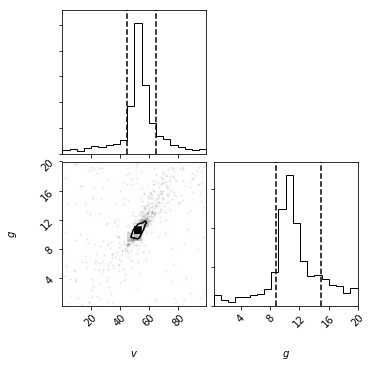

In [44]:
vparameters2d, cov2d = nestle.mean_and_cov(sample_result2d.samples, sample_result2d.weights)
print('Best fit:',    varied_param_names, '\n',vparameters2d)
print('Covariance:',  varied_param_names, '\n', cov2d)
fig = corner.corner(
    sample_result2d.samples, 
    labels=["$v$", "$g$"],
    quantiles=(0.16, 0.84),
    levels=(1-np.exp(-0.5),),
    #truths=[v, g]
    )
plt.show()

### Lets make the plot even nicer looking for the sake of illustration

DomainMinimumPoint [40  5]
DomainMaximumPoint [65 15]
PlugInPointsCount 10000
PointsToPlugInDataset.shape (10000, 2)
PointsToPlugInDataset[0] [40.  5.]
MaxObservedValue [0.01119657]
MinObservedValue [1.95785525e-05]
Z.shape (100, 100)


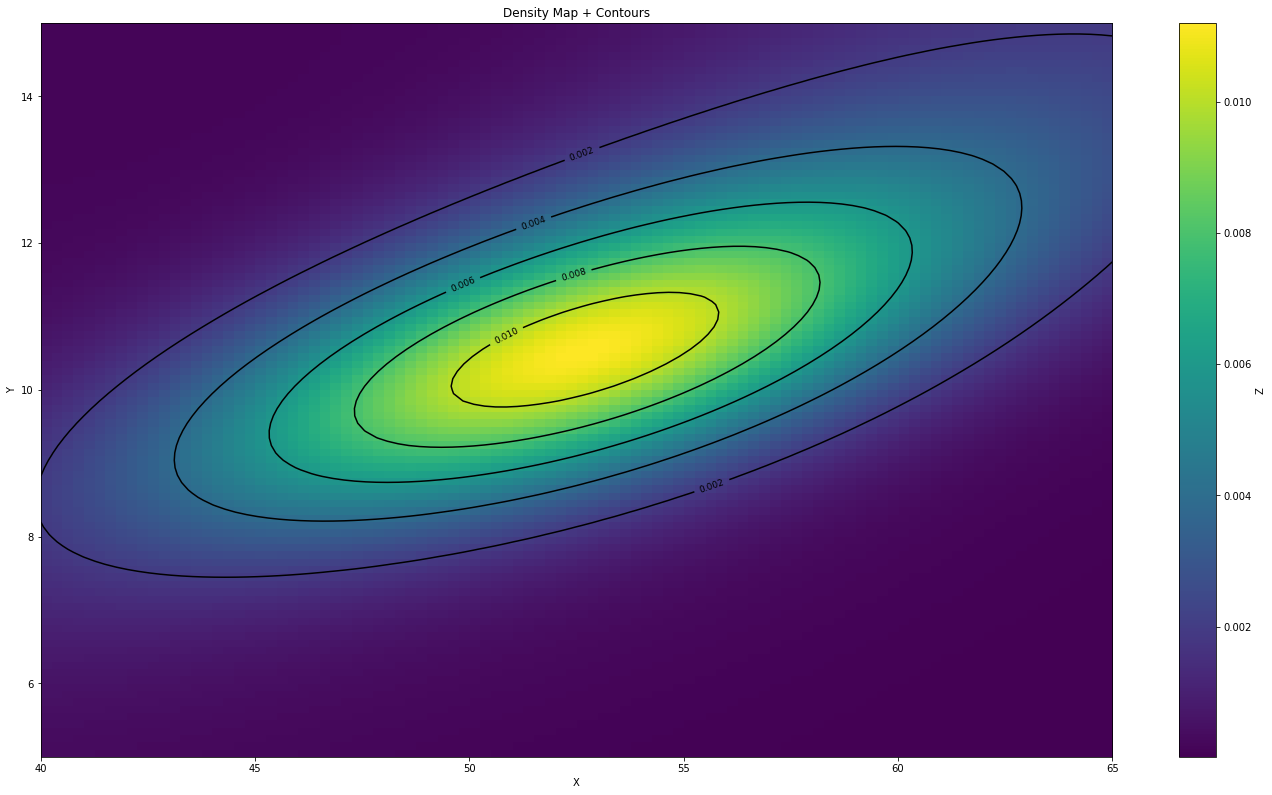

In [45]:
values = sample_result2d.samples
kernel2d = scipy.stats.gaussian_kde( values.T ) #takes in points sideways....
Library_GraphTwoDimensionDensityColorMap.Main(
    Function = kernel2d.pdf,
    DomainMinimumPoint  = numpy.array([40, 5]),
    DomainMaximumPoint  = numpy.array([65, 15]),
    ShowContours = True,
    PrintExtra = False,
    )



In [ ]:
kernel2d_v_marginal = scipy.stats.gaussian_kde( values.T[0] ) 
Points = numpy.linspace(30, 90, 100)
Values = kernel2d_v_marginal.pdf(Points)
plt.plot(Points,  Values, )
plt.ylabel( "probability",fontsize = 14 )
plt.xlabel( "$v$",fontsize = 14 )
plt.show()

In [ ]:
kernel2d_g_marginal = scipy.stats.gaussian_kde( values.T[1] ) 
Points = numpy.linspace(0, 20, 100)
Values = kernel2d_g_marginal.pdf(Points)
plt.plot(Points,  Values, )
plt.ylabel( "probability",fontsize = 14 )
plt.xlabel( "$g$",fontsize = 14 )
plt.show()